In [1]:
%load_ext autoreload
%autoreload 2
import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

logger = logging.getLogger()

In [2]:
from LCNE_patchseq_analysis.pipeline_util.metadata import read_brian_spreadsheet, cross_check_metadata

##  Load patchseq metadata and perform cross check

In [6]:
# If run in CO, we cannot access LIMS
dfs = read_brian_spreadsheet(file_path="/root/capsule/data/IVSCC_LC_summary.xlsx", add_lims=False)
for source in ["tab_xyz", "tab_ephys_fx"]:
    df_inconsistencies = cross_check_metadata(dfs["df_merged"], source)

INFO: Reading metadata from /root/capsule/data/IVSCC_LC_summary.xlsx...


INFO: 
INFO: --------------------------------------------------
INFO: Cross-checking metadata between tab_xyz and master tables...
INFO: Source columns: ['x_tab_xyz', 'y_tab_xyz', 'z_tab_xyz', 'Annotated structure_tab_xyz', 'notes_tab_xyz']
INFO: Master columns: ['x_tab_master', 'y_tab_master', 'z_tab_master', 'Annotated structure_tab_master', 'notes_tab_master']
2023-09-01 Dbh-Cre_KH212;RCL-H2B-GFP-692026.10.10.02  10534.982420 10151.01953
2023-08-20 Dbh-Cre_KH212;RCL-H2B-GFP-692023.08.06.01  10541.875980 10702.28320
2023-08-20 Dbh-Cre_KH212;RCL-H2B-GFP-692023.08.06.02  10702.283200 10761.00195
2023-06-02 Dbh-Cre_KH212;RCL-H2B-GFP-676766.10.06.03  10521.757810 10541.87598
2023-03-15                   C57BL6J-665266.11.06.03  10451.809570 10534.98242
2023-01-20     Ndnf-IRES2-dgCre;Ai14-659663.11.06.03  10391.497070 10521.75781
2023-01-20     Ndnf-IRES2-dgCre;Ai14-659663.11.06.04   9531.198242 10451.80957
2023-09-01 Dbh-Cre_KH212;RCL-H2B-GFP-692026.10.10.02   4183.531250 3701.974609
20

### ❌ Oh no! These inconsistencies must be caused by manually copying and pasting across the tabs!!!

## Quick overview using pygwalker

In [14]:
!pip install pygwalker --quiet

In [15]:
import pygwalker as pyg
walker = pyg.walk(df)
walker

NameError: name 'df' is not defined

## Extract AP

In [9]:
df_merged, df_tab_ephys_fx = dfs["df_merged"], dfs["df_tab_ephys_fx"]
df_merged.columns

Index(['Date', 'donor', 'jem-id_cell_specimen', 'cell_specimen_id',
       'type of experiment', 'injection region', 'virus',
       'jem-status_reporter', 'jem-id_patched_cell_container',
       'jem-id_patched_cell_container.1',
       ...
       'peak_deltav_hero', 'first_isi_inv_rheo', 'first_isi_inv_hero',
       'upstroke_downstroke_ratio_short_square', 'threshold_v_short_square',
       'width_short_square', 'upstroke_short_square',
       'downstroke_short_square', 'width_suprathresh_short_square',
       'peak_deltav_short_square'],
      dtype='object', length=131)

In [10]:
[col for col in df_merged.columns if "roi" in col]

['jem-roi_minor', 'ephys_roi_id']

In [11]:
[col for col in df_tab_ephys_fx.columns if "rheo" in col]

['rheobase_i',
 'latency_rheo',
 'avg_rate_rheo',
 'mean_isi_rheo',
 'upstroke_downstroke_ratio_rheo',
 'threshold_v_rheo',
 'peak_v_rheo',
 'width_rheo',
 'upstroke_rheo',
 'downstroke_rheo',
 'width_suprathresh_rheo',
 'trough_v_rheo',
 'fast_trough_v_rheo',
 'postap_slope_rheo',
 'fast_trough_v_last_rheo',
 'adp_v_last_rheo',
 'trough_slowdeltav_rheo',
 'fast_trough_deltav_rheo',
 'peak_deltav_rheo',
 'first_isi_inv_rheo']

In [12]:
[col for col in df_tab_ephys_fx.columns if "hero" in col]

['adapt_hero',
 'avg_rate_hero',
 'latency_hero',
 'mean_isi_hero',
 'median_isi_hero',
 'isi_cv_hero',
 'ir_late_hero',
 'upstroke_downstroke_ratio_hero',
 'threshold_v_hero',
 'peak_v_hero',
 'width_hero',
 'upstroke_hero',
 'downstroke_hero',
 'width_suprathresh_hero',
 'trough_v_hero',
 'fast_trough_v_hero',
 'postap_slope_hero',
 'ahp_delay_ratio_hero',
 'trough_slowdeltav_hero',
 'fast_trough_deltav_hero',
 'peak_deltav_hero',
 'first_isi_inv_hero']

## Load one nwb

In [2]:
RAW_DIRECTORY = "/root/capsule/data/LCNE-patchseq-ephys-raw"
ephys_roi_id = "1410790193"
raw_path_this = f"{RAW_DIRECTORY}/Ephys_Roi_Result_{ephys_roi_id}"

In [3]:
import glob
nwbs = glob.glob(f"{raw_path_this}/*.nwb")
jsons = glob.glob(f"{raw_path_this}/*.json")
nwbs

['/root/capsule/data/LCNE-patchseq-ephys-raw/Ephys_Roi_Result_1410790193/1410790193_1410793600_spikes.nwb',
 '/root/capsule/data/LCNE-patchseq-ephys-raw/Ephys_Roi_Result_1410790193/Dbh-Cre-KI;Ai65-773002.06.01.01.nwb']

In [15]:
[j for j in jsons if "input" in j]

['/root/capsule/data/LCNE-patchseq-ephys-raw/Ephys_Roi_Result_1410790193/EPHYS_QC_V3_QUEUE_1410790193_input.json',
 '/root/capsule/data/LCNE-patchseq-ephys-raw/Ephys_Roi_Result_1410790193/EPHYS_FEATURE_EXTRACTION_V3_QUEUE_1410790193_input.json',
 '/root/capsule/data/LCNE-patchseq-ephys-raw/Ephys_Roi_Result_1410790193/EPHYS_NWB_STIMULUS_SUMMARY_V3_QUEUE_1410790193_input.json']

In [16]:
[j for j in jsons if "output" in j]

['/root/capsule/data/LCNE-patchseq-ephys-raw/Ephys_Roi_Result_1410790193/202412181106_EPHYS_NWB_STIMULUS_SUMMARY_V3_QUEUE_1410790193_output.json',
 '/root/capsule/data/LCNE-patchseq-ephys-raw/Ephys_Roi_Result_1410790193/202412181110_EPHYS_QC_V3_QUEUE_1410790193_output.json',
 '/root/capsule/data/LCNE-patchseq-ephys-raw/Ephys_Roi_Result_1410790193/202412181120_EPHYS_FEATURE_EXTRACTION_V3_QUEUE_1410790193_output.json']

In [1]:
[j for j in jsons if "output" in j]

NameError: name 'jsons' is not defined

## Json

In [38]:
from LCNE_patchseq_analysis.data_util.metadata import read_json_files, jsons_to_df
import pandas as pd

In [9]:
json_dicts = read_json_files()

In [39]:
df_merged = jsons_to_df(json_dicts)

In [42]:
df_merged.columns

Index(['sweep_number', 'stimulus_units', 'bridge_balance_mohm', 'leak_pa',
       'stimulus_scale_factor', 'stimulus_code', 'stimulus_code_ext',
       'clamp_mode', 'stimulus_name', 'tags', 'stimulus_start_time',
       'stimulus_amplitude', 'stimulus_duration', 'stimulus_interval',
       'pre_noise_rms_mv', 'post_vm_mv', 'post_noise_rms_mv', 'pre_vm_mv',
       'slow_vm_mv', 'slow_noise_rms_mv', 'vm_delta_mv', 'passed', 'reasons',
       'peak_deflection', 'num_spikes'],
      dtype='object')

In [43]:
df_merged

,sweep_number,stimulus_units,bridge_balance_mohm,leak_pa,stimulus_scale_factor,stimulus_code,stimulus_code_ext,clamp_mode,stimulus_name,tags,...,post_vm_mv,post_noise_rms_mv,pre_vm_mv,slow_vm_mv,slow_noise_rms_mv,vm_delta_mv,passed,reasons,peak_deflection,num_spikes
0,4,Amps,11.965812,-102.817345,10.0,X1PS_SubThresh,X1PS_SubThresh[0],CurrentClamp,Long Square,"[stim epoch is missing, experiment epoch is mi...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,Amps,11.965812,-109.718262,10.0,X1PS_SubThresh,X1PS_SubThresh[1],CurrentClamp,Long Square,"[stim epoch is missing, experiment epoch is mi...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6,Amps,11.965812,-115.416275,10.0,X1PS_SubThresh,X1PS_SubThresh[2],CurrentClamp,Long Square,[],...,-49.735069,0.049036,-49.835911,-49.835911,0.324406,0.100842,True,[],-60.406254,0.0
3,7,Amps,11.965812,-115.416275,10.0,X1PS_SubThresh,X1PS_SubThresh[3],CurrentClamp,Long Square,"[stim epoch is missing, experiment epoch is mi...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8,Amps,11.965812,-115.416275,10.0,X1PS_SubThresh,X1PS_SubThresh[4],CurrentClamp,Long Square,[],...,-50.861950,0.044597,-49.705349,-49.705349,0.374656,1.156601,False,[Vm delta: 1.157 above threshold:1.000],NaN,NaN
5,9,Amps,11.965812,-115.416275,10.0,X1PS_SubThresh,X1PS_SubThresh[5],CurrentClamp,Long Square,[],...,-50.926319,0.045038,-49.741871,-49.741871,0.235074,1.184448,False,[Vm delta: 1.184 above threshold:1.000],NaN,NaN
6,10,Amps,11.965812,-115.416275,10.0,X1PS_SubThresh,X1PS_SubThresh[6],CurrentClamp,Long Square,[],...,-50.168419,0.043851,-49.110603,-49.110603,0.296813,1.057816,False,[Vm delta: 1.058 above threshold:1.000],NaN,NaN
7,11,Amps,11.965812,-115.416275,10.0,X1PS_SubThresh,X1PS_SubThresh[7],CurrentClamp,Long Square,"[stim epoch is missing, experiment epoch is mi...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,12,Amps,11.965812,-115.416275,10.0,X1PS_SubThresh,X1PS_SubThresh[8],CurrentClamp,Long Square,"[stim epoch is missing, experiment epoch is mi...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,13,Amps,11.965812,-121.620766,10.0,X1PS_SubThresh,X1PS_SubThresh[9],CurrentClamp,Long Square,[],...,-50.575024,0.038945,-49.163368,-49.163368,0.442225,1.411655,False,[Vm delta: 1.412 above threshold:1.000],NaN,NaN


In [141]:
list(hdf)

['identifier',
 'file_create_date',
 'session_start_time',
 'session_description',
 'timestamps_reference_time',
 'general',
 'stimulus',
 'acquisition',
 'processing',
 'analysis',
 'specifications',
 'intervals']

In [151]:
list(stimulus["presentation"]["data_00000_DA0"])

['electrode', 'gain', 'data', 'starting_time']

In [212]:
trace = nwb.acquisition[f"data_{n:05}_AD0"].data[:]
stimulus = nwb.stimulus[f"data_{n:05}_DA0"].data[:]

len(trace), len(stimulus)

(160999, 160999)

In [214]:
import panel as pn
import matplotlib.pyplot as plt
import numpy as np

sampling_rate = 50000
dt_ms = 1 / sampling_rate * 1000

# Initialize Panel extension
pn.extension()

# Create slider widget
n_slider = pn.widgets.IntSlider(name='Sweep number', start=0, end=74, value=25)

# Define plotting function
def plot_raw(n):
    # Using hdf (doesn't work with Panel inside jupyter)
    # trace = np.array(hdf[f"/acquisition/data_{n:05}_AD0/data"])
    # stimulus = np.array(hdf[f"/stimulus/presentation/data_{n:05}_AD0/data"])

    # Using nwb
    trace = nwb.acquisition[f"data_{n:05}_AD0"].data[:]
    stimulus = nwb.stimulus[f"data_{n:05}_DA0"].data[:]
    time = np.arange(len(trace)) * dt_ms
    
    fig, ax = plt.subplots(2, 1, figsize=(6, 4))
    ax[0].plot(time, trace)
    ax[0].set_title(f'Sweep number {n}')
    
    ax[1].plot(time, stimulus)
    plt.close(fig)  # Prevents duplicate display
    return fig

# Use the @pn.depends decorator to update the plot whenever the slider value changes
@pn.depends(n_slider)
def update_plot(n):
    return plot_raw(n)

# Arrange the slider and plot in a vertical layout
app = pn.Column(n_slider, update_plot)
app

<IPython.core.display.Javascript object>

BokehModel(combine_events=True, render_bundle={'docs_json': {'a3072bbd-8039-4312-8e99-97bb8c3fd6e9': {'version…

<IPython.core.display.Javascript object>

2025-03-12 22:48:10,282 ERROR: panel.reactive - Callback failed for object named 'Sweep number' changing property {'value': 32} 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/panel/reactive.py", line 391, in _process_events
    self.param.update(**self_params)
  File "/opt/conda/lib/python3.9/site-packages/param/parameterized.py", line 2406, in update
    restore = dict(self_._update(arg, **kwargs))
  File "/opt/conda/lib/python3.9/site-packages/param/parameterized.py", line 2439, in _update
    self_._batch_call_watchers()
  File "/opt/conda/lib/python3.9/site-packages/param/parameterized.py", line 2624, in _batch_call_watchers
    self_._execute_watcher(watcher, events)
  File "/opt/conda/lib/python3.9/site-packages/param/parameterized.py", line 2586, in _execute_watcher
    watcher.fn(*args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/panel/param.py", line 914, in _replace_pane
    self._update_inner(new_object)
  File "/opt/conda/lib

TypeError: '<=' not supported between instances of 'Version' and 'Version'

<IPython.core.display.Javascript object>

2025-03-12 22:48:10,863 ERROR: panel.reactive - Callback failed for object named 'Sweep number' changing property {'value': 36} 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/panel/reactive.py", line 391, in _process_events
    self.param.update(**self_params)
  File "/opt/conda/lib/python3.9/site-packages/param/parameterized.py", line 2406, in update
    restore = dict(self_._update(arg, **kwargs))
  File "/opt/conda/lib/python3.9/site-packages/param/parameterized.py", line 2439, in _update
    self_._batch_call_watchers()
  File "/opt/conda/lib/python3.9/site-packages/param/parameterized.py", line 2624, in _batch_call_watchers
    self_._execute_watcher(watcher, events)
  File "/opt/conda/lib/python3.9/site-packages/param/parameterized.py", line 2586, in _execute_watcher
    watcher.fn(*args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/panel/param.py", line 914, in _replace_pane
    self._update_inner(new_object)
  File "/opt/conda/lib

TypeError: '<=' not supported between instances of 'Version' and 'Version'

In [216]:
import panel as pn
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
import numpy as np

pn.extension()

# Create a slider widget
n_slider = pn.widgets.IntSlider(name='Sweep number', start=0, end=74, value=25)

# Initialize the data using the current slider value (n=25)
trace = nwb.acquisition[f"data_{25:05}_AD0"].data[:]
stimulus = nwb.stimulus[f"data_{25:05}_DA0"].data[:]
x = np.arange(len(trace)) * dt_ms

# Create ColumnDataSources for the trace and stimulus
source_trace = ColumnDataSource(data=dict(x=x, y=trace))
source_stimulus = ColumnDataSource(data=dict(x=x, y=stimulus))

# Create two Bokeh figures sharing the same x_range
p1 = figure(height=200, width=600, title=f'Sweep number {n_slider.value} - Trace',
            tools="pan,wheel_zoom,box_zoom,reset", x_axis_label='Samples', output_backend='webgl')
p1.line('x', 'y', source=source_trace, line_width=2)

p2 = figure(height=200, width=600, x_range=p1.x_range, title='Stimulus',
            tools="pan,wheel_zoom,box_zoom,reset", x_axis_label='Samples', output_backend='webgl')
p2.line('x', 'y', source=source_stimulus, line_width=2, line_color="orange")

# Define an update function that modifies the data sources
def update_data(n):
    # Update the title of the first plot
    p1.title.text = f'Sweep number {n} - Trace (loading...)'
    
    # Retrieve new data from nwb for the given sweep number n
    new_trace = nwb.acquisition[f"data_{n:05}_AD0"].data[:]
    new_stimulus = nwb.stimulus[f"data_{n:05}_DA0"].data[:]
    # Create a new x-axis array based on the new data length
    new_x = np.arange(len(new_trace)) * dt_ms
    p1.title.text = f'Sweep number {n} - Trace (plotting...)'
    
    # Update the data sources in place
    source_trace.data = dict(x=new_x, y=new_trace)
    source_stimulus.data = dict(x=new_x, y=new_stimulus)
    p1.title.text = f'Sweep number {n} - Trace'


# Callback to update data when the slider value changes
def slider_callback(event):
    update_data(event.new)

n_slider.param.watch(slider_callback, 'value_throttled') # Use throttled to avoid updating too frequently

# Arrange the slider and plots in a vertical layout
layout = pn.Column(n_slider, p1, p2)
layout


BokehModel(combine_events=True, render_bundle={'docs_json': {'268bf846-eb95-409e-8221-d050602be395': {'version…

In [ ]:
list(hdf["processing/spikes/Sweep_20"])

['data', 'timestamps']

In [217]:
import panel as pn
import hvplot.pandas  # This registers the hvplot API on pandas objects
import pandas as pd
import numpy as np

pn.extension('hvplot')

sampling_rate = 50000
dt_ms = 1 / sampling_rate * 1000

# Create slider widget
n_slider = pn.widgets.IntSlider(name='Sweep number', start=0, end=74, value=25)

def plot_raw(n):
    # Retrieve data from the nwb file (adjust as needed for your environment)
    trace = nwb.acquisition[f"data_{n:05}_AD0"].data[:]
    stimulus = nwb.stimulus[f"data_{n:05}_DA0"].data[:]
    time = np.arange(len(trace)) * dt_ms
    
    # Create DataFrames for hvPlot
    df_trace = pd.DataFrame({'time': time, 'trace': trace})
    df_stimulus = pd.DataFrame({'time': time, 'stimulus': stimulus})
    
    # Create interactive line plots
    trace_plot = df_trace.hvplot.line(x='time', y='trace', title=f'Sweep number {n}')
    stimulus_plot = df_stimulus.hvplot.line(x='time', y='stimulus', title=f'Stimulus {n}')
    
    # Arrange the plots vertically
    return pn.Column(trace_plot, stimulus_plot)

# Use the @pn.depends decorator to update the hvPlot-based display
@pn.depends(n_slider)
def update_plot(n):
    return plot_raw(n)

# Arrange the slider and plots in a vertical layout
app = pn.Column(n_slider, update_plot)
app


TypeError: '<=' not supported between instances of 'Version' and 'Version'

## Umap

In [101]:
import seaborn as sns
import pandas as pd

from LCNE_patchseq_analysis.panel_nwb_viz import load_ephys_metadata

In [68]:
df = load_ephys_metadata()
list(df.columns[60:132])

['sag',
 'sag_area',
 'sag_tau',
 'v_baseline',
 'rheobase_i',
 'fi_fit_slope',
 'vm_for_sag',
 'input_resistance',
 'input_resistance_ss',
 'tau',
 'latency_rheo',
 'avg_rate_rheo',
 'mean_isi_rheo',
 'upstroke_downstroke_ratio_rheo',
 'threshold_v_rheo',
 'peak_v_rheo',
 'width_rheo',
 'upstroke_rheo',
 'downstroke_rheo',
 'width_suprathresh_rheo',
 'trough_v_rheo',
 'fast_trough_v_rheo',
 'postap_slope_rheo',
 'fast_trough_v_last_rheo',
 'adp_v_last_rheo',
 'adapt_hero',
 'avg_rate_hero',
 'latency_hero',
 'mean_isi_hero',
 'median_isi_hero',
 'isi_cv_hero',
 'ir_late_hero',
 'upstroke_downstroke_ratio_hero',
 'threshold_v_hero',
 'peak_v_hero',
 'width_hero',
 'upstroke_hero',
 'downstroke_hero',
 'width_suprathresh_hero',
 'trough_v_hero',
 'fast_trough_v_hero',
 'postap_slope_hero',
 'ahp_delay_ratio_hero',
 'sag_depol',
 'sag_area_depol',
 'sag_tau_depol',
 'adapt_mean',
 'isi_cv_mean',
 'ir_late_mean',
 'avg_rate_max',
 'isi_adapt_ratio',
 'width_adapt_ratio',
 'upstroke_adapt_

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Embedded shape: (271, 2)


(5.0, 15.0)

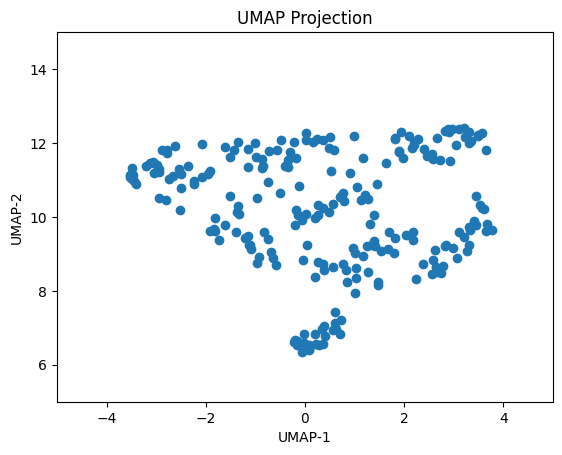

In [ ]:
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt

# Create a toy dataset (100 samples × 50 features)
X = df.iloc[:, 60:132].values

# Remove columns that has NaN
X = np.nan_to_num(X)
X.shape

# Initialize UMAP
umap_model = UMAP(
    n_neighbors=15,    # how many nearest neighbors to consider
    min_dist=0.1,      # how tightly points are packed
    n_components=2,    # target dimensionality
    random_state=42    # reproducibility
)

# Fit & transform
X_embedded = umap_model.fit_transform(X)
print("Embedded shape:", X_embedded.shape)

# 4️⃣ Visualize
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
plt.title("UMAP Projection")
plt.xlabel("UMAP‑1")
plt.ylabel("UMAP‑2")
plt.xlim([-5, 5])
plt.ylim([5, 15])

In [40]:
cols_width = [col for col in df.columns if "width" in col and "adapt_ratio" not in col]
cols_width

['width_rheo',
 'width_suprathresh_rheo',
 'width_hero',
 'width_suprathresh_hero',
 'width_short_square',
 'width_suprathresh_short_square']

In [111]:
# Find out NaN values
df[cols_width].isna().sum()

# Set any value in cols_widths > 0.01 to None
df[cols_width] = df[cols_width].mask(df[cols_width] > 0.01, None) * 1000 # in ms

In [112]:
df["injection region"].unique()

def _format_injection_region(x):
    if x != x:
        return "None"
    if "pl" in x.lower():
        return "Cortex"
    return x
    
df["injection region"] = df["injection region"].apply(_format_injection_region)

In [113]:
df["injection region"].unique()

array(['None', 'C5', 'Cortex', 'VAL', 'Crus 1'], dtype=object)

In [114]:
df_width = df[["injection region"] + cols_width].copy()

# Specify the desired order
area_order = ["None", "C5", "Cortex", "VAL", "Crus 1"]
color_order = ["lightgrey", "pink", "green", "red", "gold"]

# Convert the column to a categorical type with the given order
df_width["injection region"] = pd.Categorical(df_width["injection region"], categories=area_order, ordered=True)

# Sort the DataFrame by the categorical column
df_width = df_width.sort_values("injection region")


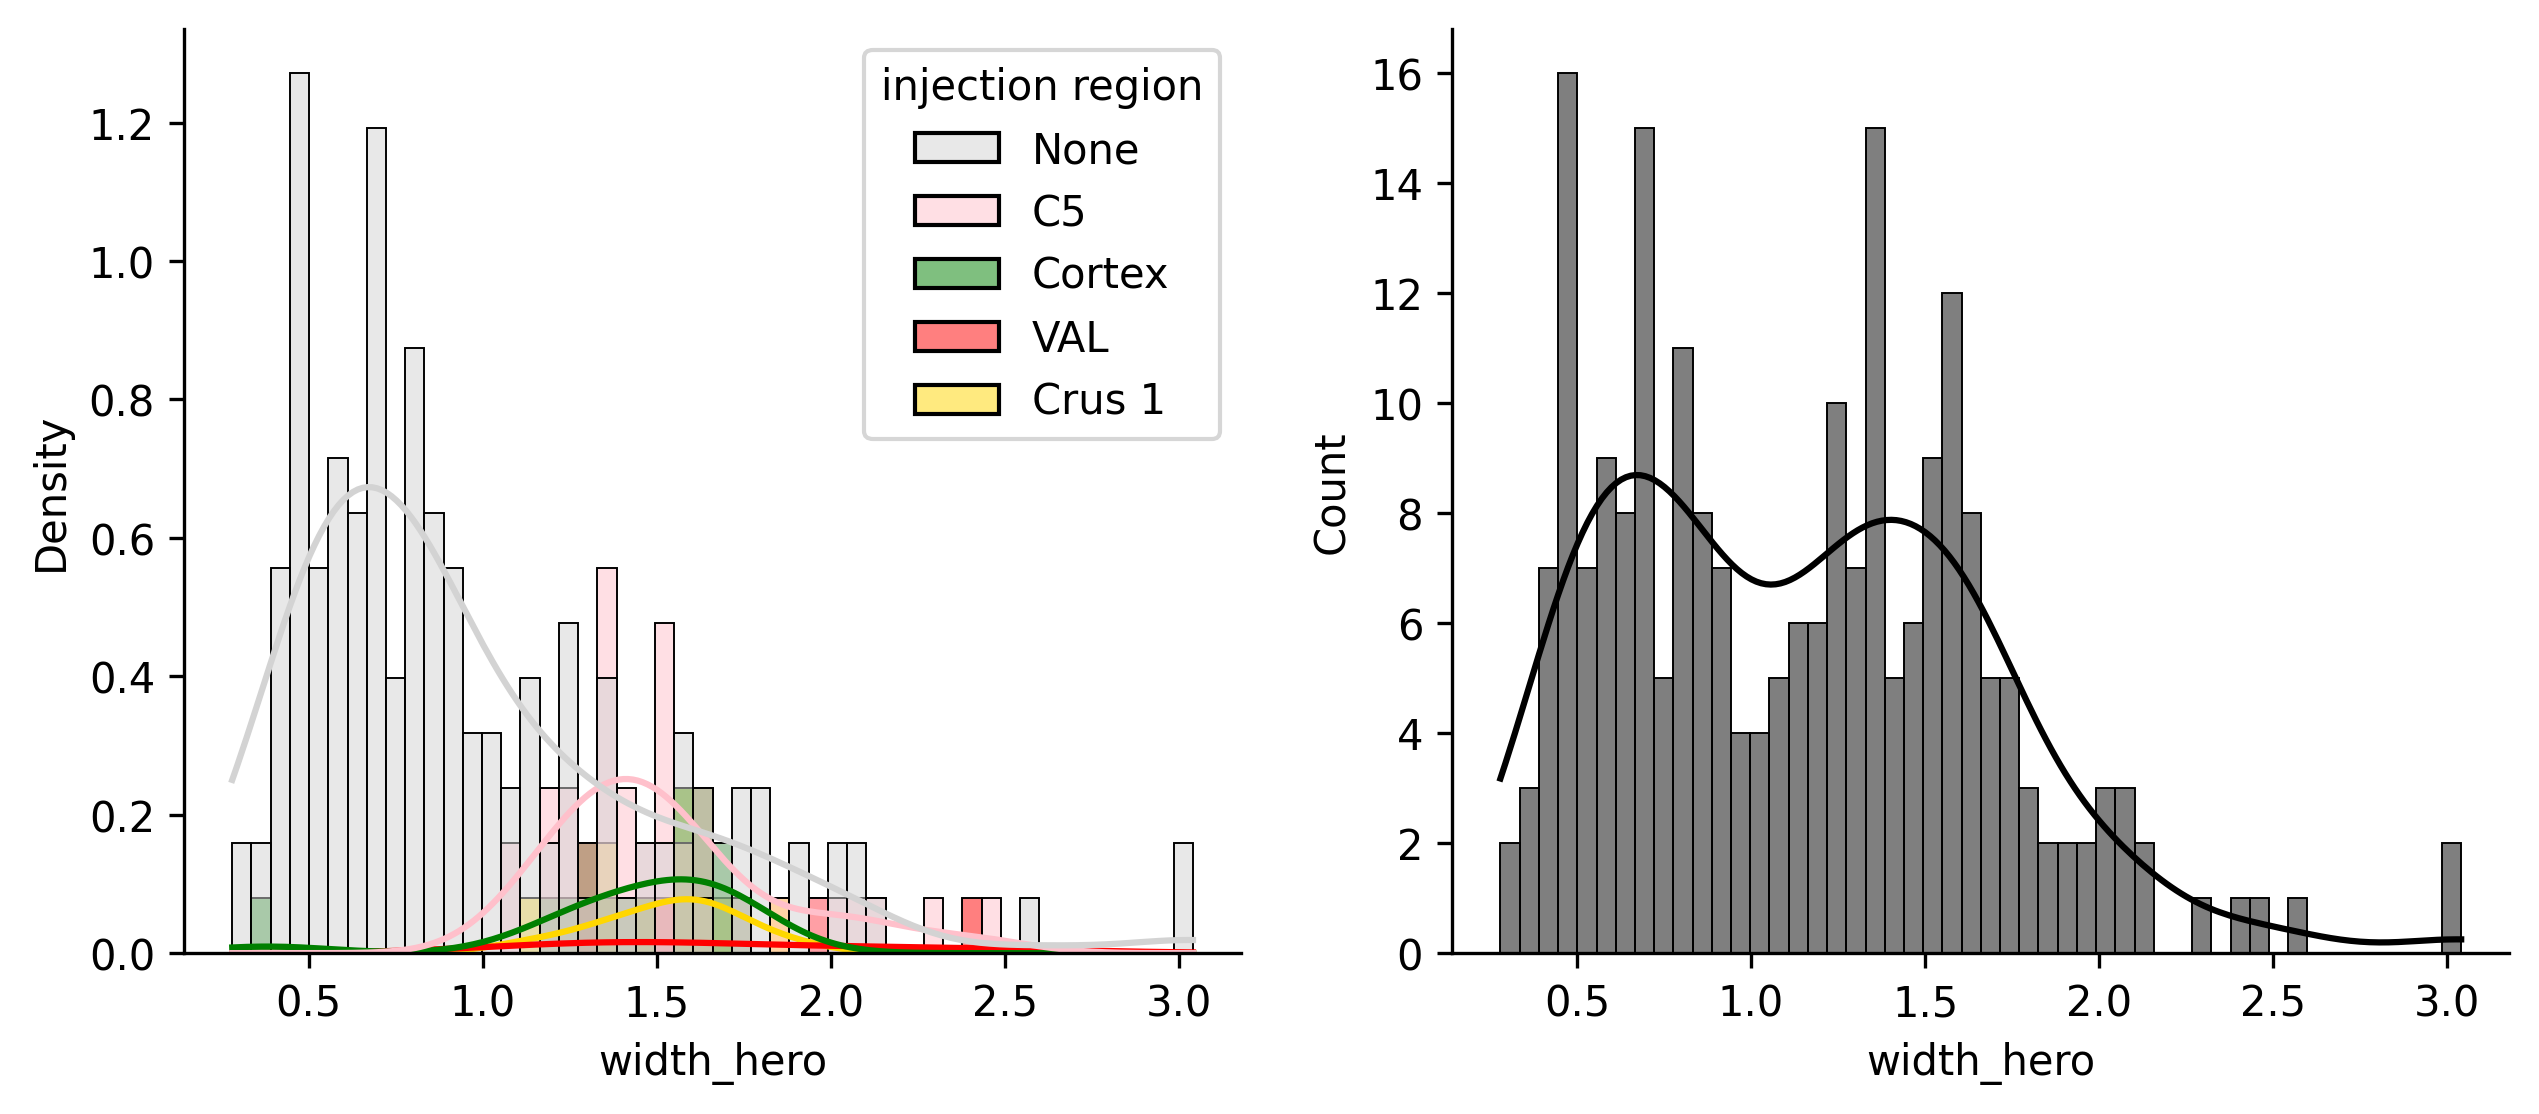

In [142]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(
    data=df_width,
    x="width_hero",
    kde=True,
    hue="injection region",
    hue_order=area_order,
    palette=color_order,
    stat="density",
    bins=50,
    ax=ax[0],
)
sns.histplot(
    data=df_width,
    x="width_hero",
    kde=True,
    stat="count",
    bins=50,
    color="black",
    ax=ax[1],
)
sns.despine()
fig.set_dpi(300)

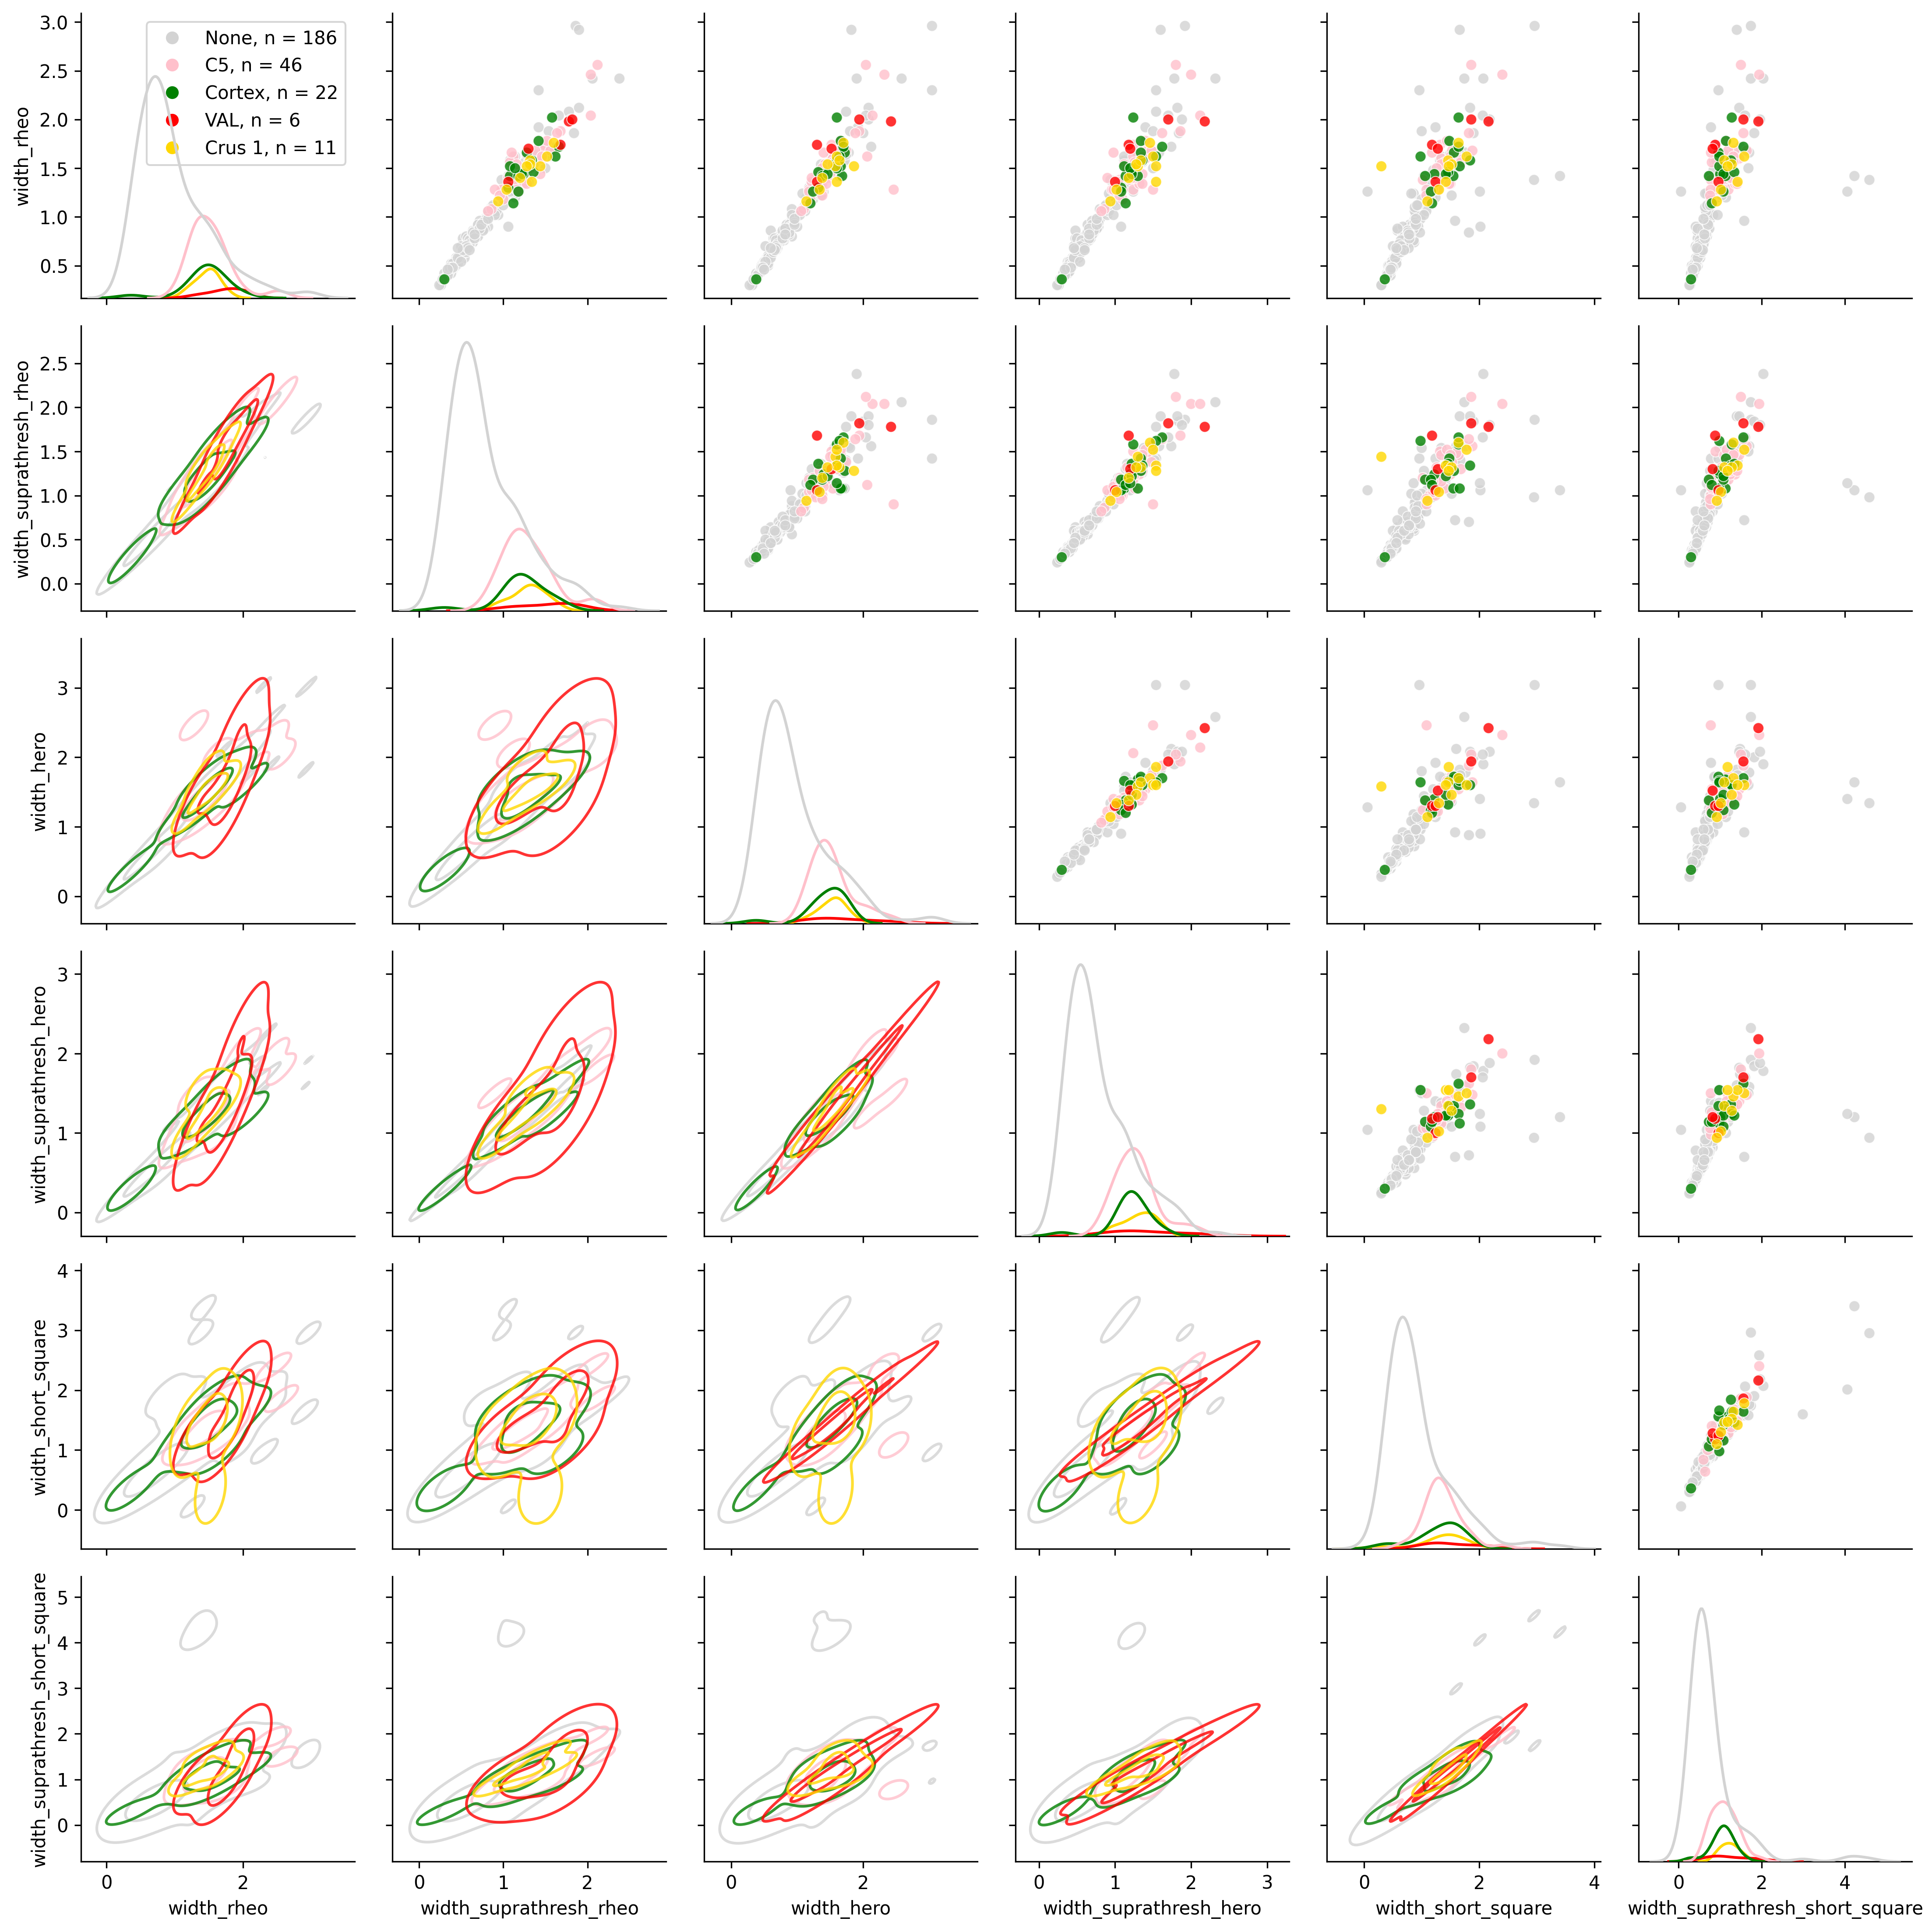

In [120]:
import matplotlib.pyplot as plt

g = sns.PairGrid(
    df_width,
    hue="injection region",
    hue_order=area_order,
    palette=color_order,
)
g.map_upper(sns.scatterplot, alpha=0.8)
g.map_lower(sns.kdeplot, fill=False, alpha=0.8, common_norm=False, levels=3)
g.map_diag(sns.kdeplot, common_norm=True, legend=True)

g.fig.set_dpi(300)

# Now, manually add a legend to one of the diagonal axes.
ax = g.axes[0, 0]  # get the first diagonal axis

# Create legend handles manually.
handles = [
    plt.Line2D(
        [],
        [],
        marker="o",
        linestyle="",
        color=color,
        label=f"{area}, n = {len(df_width[df_width['injection region'] == area])}",
    )
    for area, color in zip(
        area_order,
        color_order,
    )
]

# Add the legend to the selected diagonal axis.
ax.legend(handles=handles, loc="upper right")